### План:
1. Открытие файлов с данными и изучение информации.
2. Предобработка данных.
3. Приоритизация гипотез:
    + Приоритизация с помощью фреймворка ICE;
    + Приоритизация с помощью фреймворка RICE;
    + Оценка изменений.
4. Анализ A/B-теста:
    + Кумулятивная выручка по группам;
    + Кумулятивный средний чек по группам;
    + Относительное изменение кумулятивного среднего чека группы В к группе А;
    + Кумулятивная конверсия по группам;
    + Относительное изменение кумулятивной конверсии группы В к группе А;
    + Количество заказов по пользователям;
    + Граница аномальных пользователей;
    + Точечный график стоимостей заказов;
    + Граница аномальных заказов;
    + Различие в конверсии и среднем чеке между группами по "сырым" данным;
    + Различие в конверсии и среднем чеке между группами по "очищенным" данным.
5. Принятие решения по результатам теста.

### 1. Открытие файлов с данными и изучение общей информации.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
pd.options.display.max_columns = 40
pd.set_option('max_colwidth', 150)
import warnings
warnings.filterwarnings('ignore')

In [2]:
hypothesis = pd.read_csv('hypothesis.csv') #загружаем датасет с гипотезами
orders = pd.read_csv('orders.csv') #загружаем датасет с заказами
visitors = pd.read_csv('visitors.csv') #загружаем датасет с посетителями

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В этом датафрейме, для удобства, приведём названия столбцов к нижнему регистру.

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders['revenue'].describe().astype('int')

count       1197
mean        8348
std        39191
min           50
25%         1220
50%         2978
75%         8290
max      1294500
Name: revenue, dtype: int64

В этом датафрейме необходимо привести столбец с датой к типу datetime. Названия столбцов приведём к нижнему регистру. Также видим, что, как минимум, одно значние является аномальным. Возможно, есть ещё.

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors['visitors'].describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

В этом датафрейме необходмо привести дату к формату datetime. Аномальных показателей в данном датафрейме нет.

### 2. Предобработка данных.

In [11]:
hypothesis.columns = map(str.lower, hypothesis.columns) 
#приведём названия столбцов датасета с гипотезами к нижнему регистру

In [12]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 
#приводим столбец с датой к типу datetime

In [13]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [14]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#приводим столбец с датой к типу datetime

### 3. Приоритизация гипотез

In [15]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'] 
#посчитаем ICE

In [16]:
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False) 
#выведем гипотезы в порядке убывания ICE

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [17]:
display(hypothesis['hypothesis'][8])
display(hypothesis['hypothesis'][0])
display(hypothesis['hypothesis'][7])

'Запустить акцию, дающую скидку на товар в день рождения'

'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'

'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

Наиболее переспективные гипотезы по ICE: 8, 0 и 7

In [18]:
hypothesis['rice'] = (hypothesis['reach'] 
                      * hypothesis['impact'] 
                      * hypothesis['confidence']
                     ) / hypothesis['efforts']
#посчитаем RICE

In [19]:
hypothesis.sort_values(by='rice', ascending=False) 
#выведем гипотезы в порядке убывания RICE

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


In [20]:
display(hypothesis['hypothesis'][7])
display(hypothesis['hypothesis'][0])

'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'

По RICE явно лидирует гипотеза 7, так как её внедрение затронет всех пользователей. Также хорошие показатели у гипотезы 0, однако у неё очень малый охват. Гипотез 8, лидирующая по ICE, находится в середине приоритизации, так как она затрагивает только тех пользователей, кто указал дату рождения и эта дата находится во временном отрезке, который будет занимать исследование. Соответственно, у неё показатель охвата равен 1.

### 4. Анализ A/B-теста.

In [21]:
orders_a_daily = (orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':pd.Series.nunique, 'revenue':'sum'}))
#выберем только посетителей группы А, сосчитаем количество заказов и выручку за каждый день

In [22]:
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
#переименуем столбцы для удобства

In [23]:
orders_a_cumulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
    {'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}
    ), axis=1).sort_values(by='date')
#посчитаем кумулятивную выручку и количество заказов

In [24]:
orders_a_cumulative.columns = ['date', 'orders_cum_a', 'revenue_cum_a']
#переименуем столбцы для удобства

In [25]:
orders_a_cumulative['avg_check_a'] = orders_a_cumulative['revenue_cum_a'] / orders_a_cumulative['orders_cum_a']
#посчитаем средний чек

In [26]:
orders_b_daily = (orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':pd.Series.nunique, 'revenue':'sum'}))
#выберем только посетителей группы B, сосчитаем количество заказов и выручку за каждый день

In [27]:
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']
#переименуем столбцы для удобства

In [28]:
orders_b_cumulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
    {'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}
    ), axis=1).sort_values(by='date')
#посчитаем кумулятивную выручку и количество заказов

In [29]:
orders_b_cumulative.columns = ['date', 'orders_cum_b', 'revenue_cum_b']
#переименуем столбцы для удобства

In [30]:
orders_b_cumulative['avg_check_b'] = orders_b_cumulative['revenue_cum_b'] / orders_b_cumulative['orders_cum_b']
#посчитаем средний чек

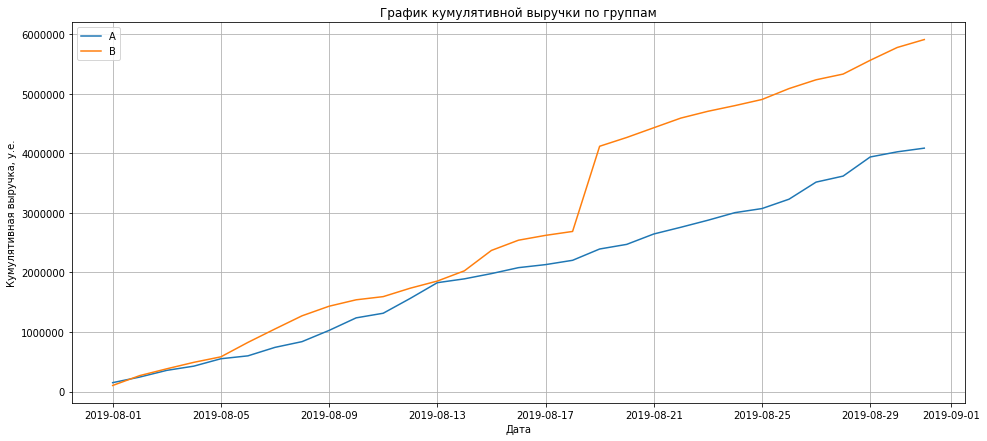

In [31]:
plt.figure(figsize=(16,7))
plt.grid()
plt.plot(orders_a_cumulative['date'], orders_a_cumulative['revenue_cum_a'], label='A')
plt.plot(orders_b_cumulative['date'], orders_b_cumulative['revenue_cum_b'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, у.е.')
plt.show()

###### 19 августа происходит резкий скачок по выручке группы B, а далее линии идут параллельно. Скорее всего, 19 августа был какой-то аномально крупный заказ.

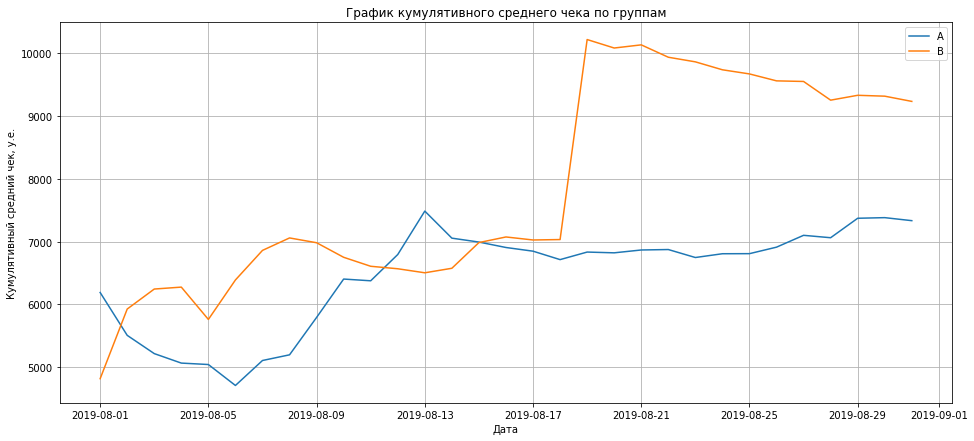

In [32]:
plt.figure(figsize=(16,7))
plt.grid()
plt.plot(orders_a_cumulative['date'], orders_a_cumulative['avg_check_a'], label='A')
plt.plot(orders_b_cumulative['date'], orders_b_cumulative['avg_check_b'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, у.е.')
plt.legend()
plt.show()

###### Средний чек группы B снова показывает аномальный скачок 19 августа из-за крупного заказа. По-началу средний чек группы В выше, но к 12 августа показатели групп примерно сравниваются. Далее скачок в группе В, который повлиял на дальнейшие показатели. Скорее всего, если исключить этот крупный заказ из нашего исслеования, средние чеки групп А и В будут примерно на одном уровне.

In [33]:
orders_ab_cumulative = orders_a_cumulative.merge(orders_b_cumulative, on='date')
#обьединим кумулятивные таблицы групп

In [34]:
orders_ab_cumulative['relative_avg_check'] = orders_ab_cumulative['avg_check_b'] / orders_ab_cumulative['avg_check_a'] - 1
#посчитаем относительное изменение среднего чека группы В к группе А

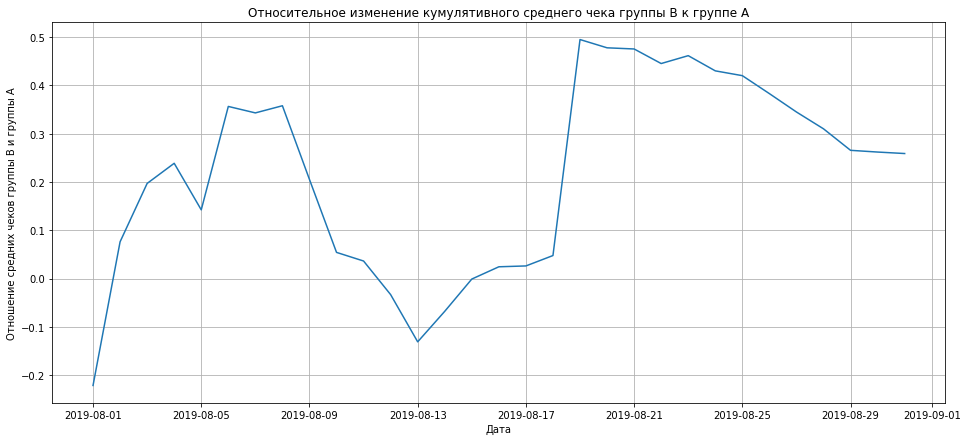

In [35]:
plt.figure(figsize=(16,7))
plt.grid()
plt.plot(orders_ab_cumulative['date'], orders_ab_cumulative['relative_avg_check'])
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков группы В и группы А')
plt.show()

###### График не показывает какой-то стабильности. Средний чек разных групп лидирует с переменным успехом. Резкий взлёт среднего чека В к А 19 августа связан с аномальным заказом.

In [36]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
#выберем только посетителей группы А и их количество за каждый день

In [37]:
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
#переименуем столбцы для удобства

In [38]:
visitors_a_cumulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
    {'date':'max', 'visitors_per_date_a':'sum'}), axis=1
).sort_values(by='date')
#посчитаем кумулятивное количество визитов

In [39]:
visitors_a_cumulative.columns = ['date', 'visitors_cum_a']
#переименуем столбцы для удобства

In [40]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
#выберем только посетителей группы B и их количество за каждый день

In [41]:
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
#переименуем столбцы для удобства

In [42]:
visitors_b_cumulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
    {'date':'max', 'visitors_per_date_b':'sum'}), axis=1
).sort_values(by='date')
#посчитаем кумулятивное количество визитов

In [43]:
visitors_b_cumulative.columns = ['date', 'visitors_cum_b']
#переименуем столбцы для удобства

In [44]:
data_cumulative = (orders_ab_cumulative.merge(visitors_a_cumulative, on='date')
                   .merge(visitors_b_cumulative, on='date'))
#объединим таблицу кумулятивных показателей заказов с посетителями

In [45]:
data_cumulative['conversion_a'] = data_cumulative['orders_cum_a'] / data_cumulative['visitors_cum_a']
#посчитаем кумулятивную конверсию группы А

In [46]:
data_cumulative['conversion_b'] = data_cumulative['orders_cum_b'] / data_cumulative['visitors_cum_b']
#посчитаем кумулятивную конверсию группы В

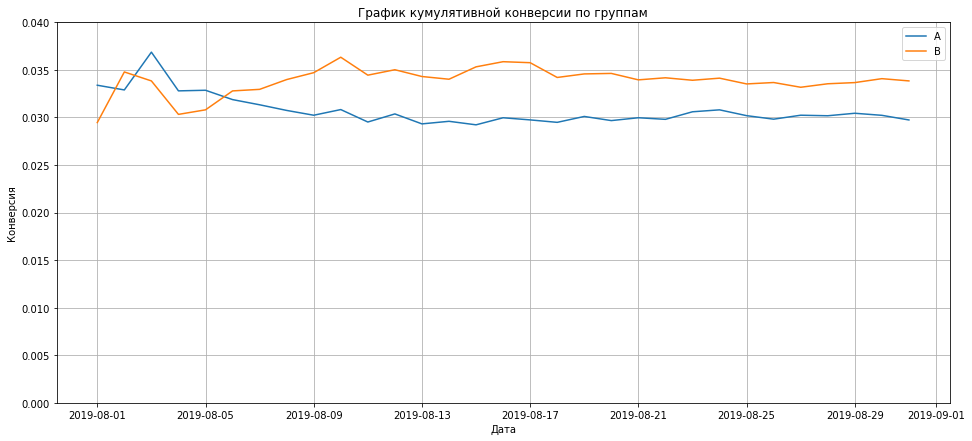

In [47]:
plt.figure(figsize=(16,7))
plt.grid()
plt.plot(data_cumulative['date'], data_cumulative['conversion_a'], label='A')
plt.plot(data_cumulative['date'], data_cumulative['conversion_b'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.ylim([0, 0.04])
plt.legend()
plt.show()

###### Практически сразу, с 6 августа конверсия группы В стабильно больше конверсии группы А. Значит, мы можем предполагать, что изменения показывают положительный результат.

In [48]:
data_cumulative['relative_conversion'] = data_cumulative['conversion_b'] / data_cumulative['conversion_a'] - 1
#посчитаем относительное изменение кумулятивной конверсии группы В к группе А

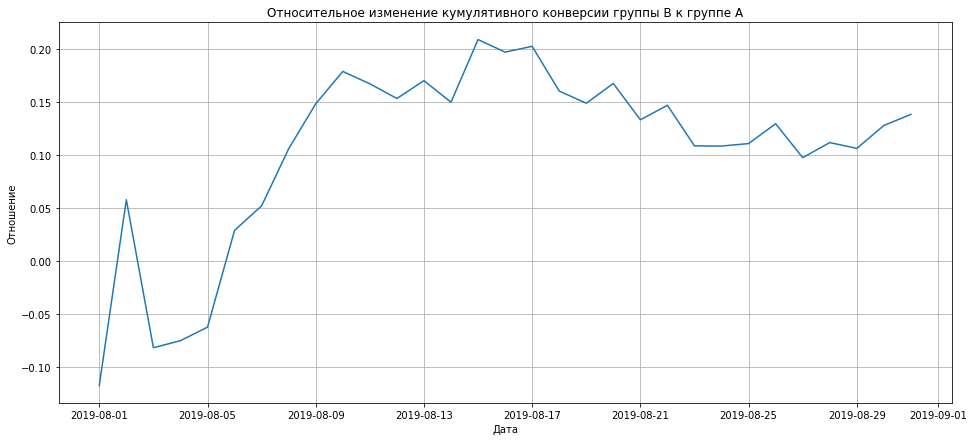

In [49]:
plt.figure(figsize=(16,7))
plt.grid()
plt.plot(data_cumulative['date'], data_cumulative['relative_conversion'])
plt.title('Относительное изменение кумулятивного конверсии группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение')
plt.show()

###### Группа В стабильно лучше группы А. Значит, если данных достаточно для статистической значимости, то можно останавливать тест.

In [50]:
orders_by_users = orders.drop(['date', 'revenue', 'group'], axis=1)\
    .groupby('visitor_id',as_index=False)\
    .agg({'transaction_id':'nunique'})
#посчитаем количество заказов по каждому пользователю

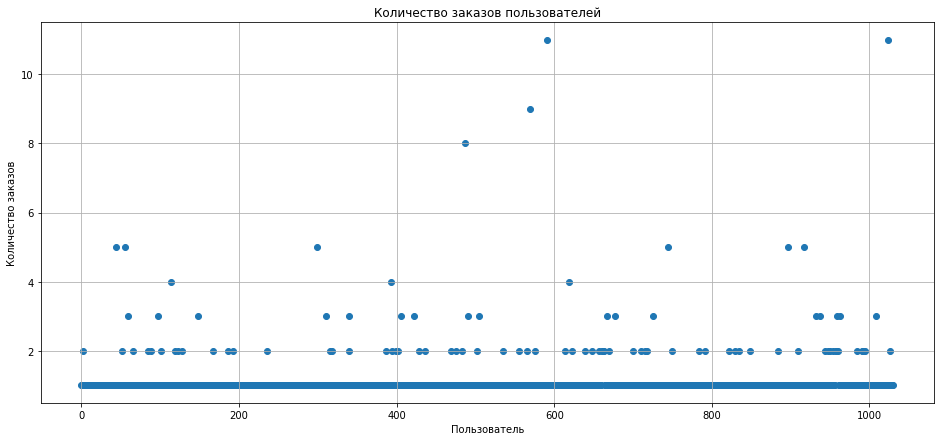

In [51]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(16,7))
plt.grid()
plt.title('Количество заказов пользователей')
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.xlabel('Пользователь')
plt.ylabel('Количество заказов')
plt.show()

###### Большинство пользователей делали покупки только один раз. Также немало пользователей, заказавших дважды. Реже встречаются пользователи сделавшие больше двух заказов. Следующим шагом найдём, каких пользователей считать аномальными.

In [52]:
np.percentile(orders_by_users['transaction_id'], [95, 99]) #посчитаем 95-й и 99-й перцентили числа заказов

array([2., 4.])

###### Не более 5% пользователей сделали больше, чем 2 заказа и не более 1% больше 4х. Выбираем пользователей с 2-мя заказами, как границу для определения аномальных заказов. То есть, пользователи, сделавшие более 2-х заказов будут считаться аномальными

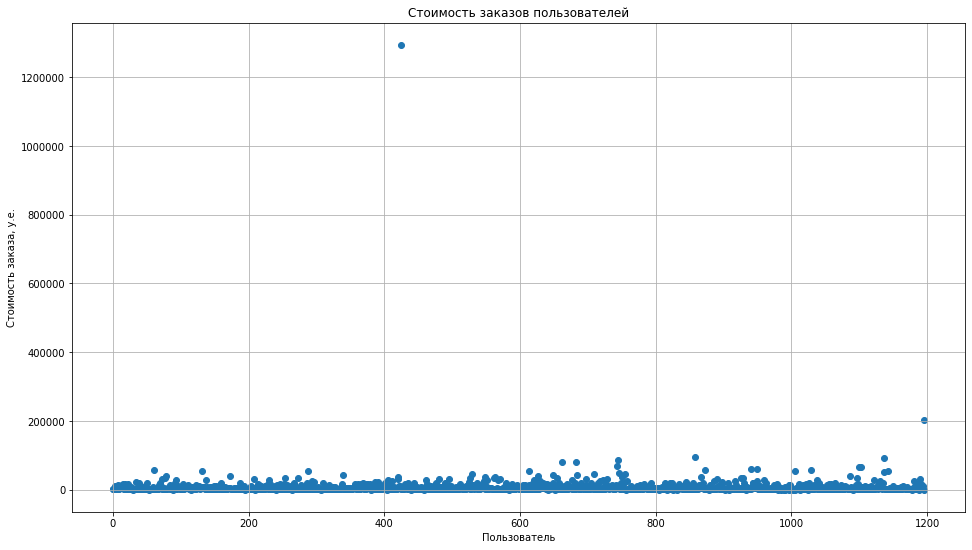

In [53]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(16,9))
plt.grid()
plt.title('Стоимость заказов пользователей')
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа, у.е.')
plt.show()

###### Большинство заказов стоимостью до 50000. Есть 1 заказ более 1200000, который, скорее всего и был совершён 19 августа. Какие заказы считать аномальными разберём следующим шагом.

In [54]:
np.percentile(orders['revenue'], [95, 99]) #посчитаем 95-й и 99-й перцентили стоимости заказов

array([28000. , 58233.2])

###### Не более 5% заказов были дороже 28000, а дороже 58233.2 не более 1%. За границу аномальной стоимости заказа выберем заказы стоимостью 28000. То есть, все заказы свыше 28000 будут считаться аномальными.

In [55]:
orders_by_users_a = orders[orders['group'] == 'A'] \
    .groupby('visitor_id', as_index=False) \
    .agg({'transaction_id':'nunique'})
#посчитаем количетсво заказов по пользователям группы А

In [56]:
orders_by_users_a.columns = ['user_id', 'orders']
#переименуем столбцы для удобства

In [57]:
orders_by_users_b = orders[orders['group'] == 'B'] \
    .groupby('visitor_id', as_index=False) \
    .agg({'transaction_id':'nunique'})
#посчитаем количетсво заказов по пользователям группы B

In [58]:
orders_by_users_b.columns = ['user_id', 'orders']
#переименуем столбцы для удобства

In [59]:
sample_a = pd.concat(
        [orders_by_users_a['orders'], pd.Series(0, 
        index=np.arange(visitors_a_daily['visitors_per_date_a'].sum() - 
                        len(orders_by_users_a['orders']))
        , name='orders')], axis = 0
)
#получим список с количеством заказов посетителей группы А, тем, кто ничего не заказал соответсвует 0

In [60]:
sample_b = pd.concat(
        [orders_by_users_b['orders'], pd.Series(0, 
        index=np.arange(visitors_b_daily['visitors_per_date_b'].sum() - 
                        len(orders_by_users_b['orders']))
        , name='orders')], axis = 0
)
#получим список с количеством заказов посетителей группы B, тем, кто ничего не заказал соответсвует 0

Далее мы посчитаем статистическую значимость различий в конверсии между группами. 
Нулевая гипотеза: значимых различий в конверсии между группами нет. Альтернативная гипотеза: различие между группами есть. Уровень значимости возьмём 0.05. 

In [61]:
display("{0:.3}".format(st.mannwhitneyu(sample_a, sample_b)[1]))
display("{0:.3}".format(sample_b.mean() / sample_a.mean() - 1))

'0.0084'

'0.138'

###### p-value < 0.05, а значит, что по "сырым" данным различия в конверсии между группами есть. Относительное увеличение конверсии группы В составляет 13.8%.

Далее мы посчитаем статистическую значимость различий в среднем чеке между группами. 
Нулевая гипотеза: значимых различий в среднем чеке между группами нет. Альтернативная гипотеза: различие между группами есть. Уровень значимости возьмём 0.05. 

In [62]:
display("{0:.3}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                        orders[orders['group']=='B']['revenue'])[1]))
display("{0:.3}".format(orders[orders['group']=='B']['revenue'].mean()  
                        / orders[orders['group']=='A']['revenue'].mean()-1))

'0.365'

'0.259'

###### p-value > 0.05,  а значит, что по"сырым" данным различия средних чеков между группами нет. Однако, средний чек группы В больше относительно группы А почти на 26%.

In [63]:
users_abnormal_orders = orders_by_users[orders_by_users['transaction_id'] > 2]['visitor_id']
#найдём пользователей с аномальным количеством заказов

In [64]:
users_abnormal_revenue = orders[orders['revenue'] > 28000]['visitor_id']
#найдём пользователей с аномальной суммой заказа

In [65]:
users_abnormal = pd.concat([users_abnormal_orders, users_abnormal_revenue], axis=0)\
    .drop_duplicates()
#объединим всех аномальных пользователей

In [66]:
sample_a_filtered = pd.concat(
        [orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(users_abnormal))]['orders'], 
        pd.Series(0, 
        index=np.arange(visitors_a_daily['visitors_per_date_a'].sum() - 
                        len(orders_by_users_a['orders']))
        , name='orders')], axis = 0
)
#получим очищенный список с количеством заказов посетителей группы А, тем, кто ничего не заказал соответсвует 0

In [67]:
sample_b_filtered = pd.concat(
        [orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(users_abnormal))]['orders'], 
        pd.Series(0, 
        index=np.arange(visitors_b_daily['visitors_per_date_b'].sum() - 
                        len(orders_by_users_b['orders']))
        , name='orders')], axis = 0
)
#получим очищенный список с количеством заказов посетителей группы B, тем, кто ничего не заказал соответсвует 0

Далее мы посчитаем статистическую значимость различий в конверсии между группами по очищенным данным. Нулевая гипотеза: значимых различий в конверсии между группами нет. Альтернативная гипотеза: различие между группами есть. Уровень значимости также возьмём 0.05.

In [68]:
display("{0:.3}".format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
display("{0:.3}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

'0.00608'

'0.176'

###### По очищенным данным мы видим, что p-value ещё меньше, а значит мы также отвергаем нулевую гипотезу, то есть, различие в конверсии между группами есть. Вырос и процент различия до 17.6%.

In [69]:
orders_a_normal = orders[np.logical_and(
    orders['group']=='A',
    np.logical_not(orders['visitor_id'].isin(users_abnormal)))]['revenue']
#получим очищенный список с суммой заказов посетителей группы А

In [70]:
orders_b_normal = orders[np.logical_and(
    orders['group']=='B',
    np.logical_not(orders['visitor_id'].isin(users_abnormal)))]['revenue']
#получим очищенный список с суммой заказов посетителей группы B

Далее мы посчитаем статистическую значимость различий в среднем чеке между группами по очищенным данным. Нулевая гипотеза: значимых различий в среднем чеке между группами нет. Альтернативная гипотеза: различие между группами есть. Уровень значимости также возьмём 0.05.

In [71]:
display("{0:.3}".format(st.mannwhitneyu(orders_a_normal, orders_b_normal)[1]))
display("{0:.3}".format(orders_b_normal.mean() / orders_a_normal.mean() - 1))

'0.376'

'-0.0221'

###### По очищенным данным также p-value больше уровня значимости, а значит, мы не можем отвергнуть нулевую гипотезу и считать, что  есть различия в среднем чеке. Однако, изменилось отношение среднего чека группы В к группе А. Теперь средний чек группы В меньше на 2% относительно группы А. На это повлияло, удаление из нашей выборки заказа с суммой выше 1200000.

### 5. Принятие решения по результатам теста.

1. Конверсия группы В стабильно лучше конверсии группы А. Статистически значимое различие по конверсии между группами есть как по "сырым" данным, так и после удаления аномальных пользователей.
2. График среднего чека не показывает какой-то определённости, а значит какие-либо выводы по нему сделать нельзя. Статистически значимого различия в среднем чеке между группами нет. Однако, различается средний чем между группами по "сырым" и очищенным данным. По сырым данным средний чек группы В выше относительно группы А на 26%, а по очищенным он уже ниже на 2%

Итог: так как конверсия группы В превосходит конверсию группы А стабильно на протяжении долгого времени и тенденции к перемене не наблюдается, а также имеется статистически значимое различие, тест можно останавливать, зафиксировав победу группы В. Исследования по различиям среднего чека мы не учитываем, так как по нему нельзя сделать выводов и нет статистически значимого различия.